In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lmfit import Model

from scipy.stats import linregress

In [7]:
# MODEL
def r_t(s, r_s, l_t, N, W, L):
    return (r_s * s / (N * W + (N-1) * (2 *s + L))) + (2 * r_s * l_t / (N * W + (N-1) * (2 *s + L)))

#Create model and parameters
gmodel5 = Model(r_t)
param5 = gmodel5.make_params()
param5['r_s'].set(value = 1e10, min = 0)
param5['l_t'].set(value = 1, min = 0)
param5['L'].set(value = 3200e-4, vary = False)
param5['W'].set(value = 5e-4, vary = False)
param5['N'].set(value = 60, vary = False)

In [8]:
def total_resistance(s, sigma, thickness, n, w, l, intercept):
    return s / (sigma * thickness * ( 2* n * (w + l + s) - l - s)) + intercept

gmodel = Model(total_resistance)
param = gmodel.make_params()
param['sigma'].set(value = 1e-6, min = 0)
param['intercept'].set(value = 1000, min = 0)
param['l'].set(value = 3200e-4, vary = False)
param['w'].set(value = 5e-4, vary = False)
param['n'].set(value = 60, vary = False)
param['thickness'].set(value = 80e-7, vary = False)

# def data():
    

C:\Users\lopezb41\AppData\Local\Temp\ipykernel_1484\1192352353.py:37: RuntimeWarning: divide by zero encountered in scalar divide
  df['Weight'] = 1 / std ** 2
C:\Users\lopezb41\AppData\Local\Temp\ipykernel_1484\1192352353.py:37: RuntimeWarning: divide by zero encountered in scalar divide
  df['Weight'] = 1 / std ** 2
C:\Users\lopezb41\AppData\Local\Temp\ipykernel_1484\1192352353.py:37: RuntimeWarning: divide by zero encountered in scalar divide
  df['Weight'] = 1 / std ** 2
C:\Users\lopezb41\AppData\Local\Temp\ipykernel_1484\1192352353.py:37: RuntimeWarning: divide by zero encountered in scalar divide
  df['Weight'] = 1 / std ** 2


[[Model]]
    Model(total_resistance)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 6000
    # data points      = 4
    # variables        = 2
    chi-square         = 6.7973e+11
    reduced chi-square = 3.3986e+11
    Akaike info crit   = 107.434642
    Bayesian info crit = 106.207231
    R-squared          = 0.96108326
##  Warning: uncertainties could not be estimated:
[[Variables]]
    sigma:      1.0752e-06 (init = 1e-06)
    thickness:  8e-06 (fixed)
    n:          60 (fixed)
    w:          0.0005 (fixed)
    l:          0.32 (fixed)
    intercept:  1.37888701 (init = 1000)
1.3788870099195303


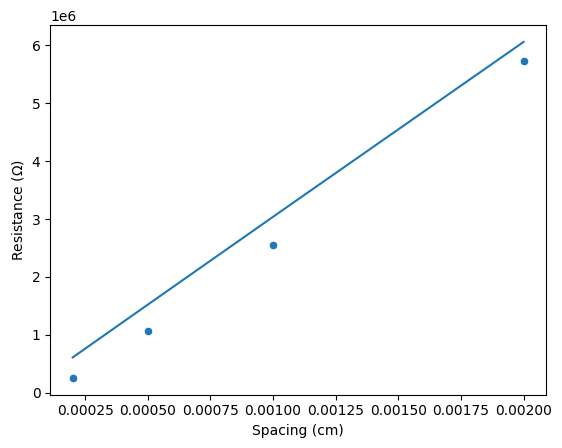

In [16]:
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Contact Resistance\LSB_07\0G_34'

col = ['Potential (V)', 'Current (A)', 'Time (s)']
col_r = ['Spacing (cm)', 'Resistance ($\Omega$)', 'Column']
i_v = pd.DataFrame()
r = pd.DataFrame(columns = col_r)
files = [os.path.join(path, i) for i in os.listdir(path)]
n = 0
for i in files:
    df = pd.read_csv(i, sep = ';', names = col, skiprows = 1)
    slope, intercept, rvalue, pvalue, stderr = linregress(df[col[0]], df[col[1]])
    df['Fit'] = df[col[0]] * slope + intercept
    if i[-5:-4] == '1':
        df[col_r[0]] = 2e-4
        r.loc[n] = [2e-4, 1/slope, i[-10:-8]]
    elif i[-5:-4] == '2':
        df[col_r[0]] = 5e-4
        r.loc[n] = [5e-4, 1/slope, i[-10:-8]]
    elif i[-5:-4] == '3':
        df[col_r[0]] = 10e-4
        r.loc[n] = [10e-4, 1/slope, i[-10:-8]]
    elif i[-5:-4] == '4':
        df[col_r[0]] = 20e-4
        r.loc[n] = [20e-4, 1/slope, i[-10:-8]]
    df['Column'] = i[-10:-8]
    i_v = pd.concat([i_v, df], ignore_index=True)
    n += 1
    
# Weight by 1/std**2
spac = [2e-4, 5e-4, 10e-4, 20e-4]
average_df = pd.DataFrame()
weights = pd.DataFrame()
for i in spac:
    df = r[r[col_r[0]] == i].mean(numeric_only=True)
    df2 = r[r[col_r[0]] == i].copy()
    std = np.std(df2[col_r[1]])
    df['Weight'] = 1 / std ** 2
    # print(len(df2))
    # df2['Weight'] = 1 / std ** 2
    average_df = pd.concat([average_df, df], axis=1)
    weights = pd.concat([weights, df2], ignore_index=True)
average_df = average_df.T.reset_index(drop = True)

average_df 
result = gmodel.fit(average_df[col_r[1]], param, s = r[col_r[0]], fit_kws={"ftol":1e-22, "xtol":1e-22, "gtol":1e-22})
print(result.fit_report())
print(result.eval(result.params, s = 0))

sns.scatterplot(data = average_df, x = col_r[0], y = col_r[1])
plt.plot(average_df[col_r[0]], result.best_fit)
# result_all = gmodel5.fit(average_df[col_r[1]], param5, s = average_df[col_r[0]], fit_kws={"ftol":1e-22, "xtol":1e-22, "gtol":1e-22}, weights = average_df['Weight'])
# rc2_all = gmodel5.eval(result_all.params, s = 0)
# rs_all = result_all.values['r_s']
# rs_err = result_all.params['r_s'].stderr
# sigma_all = 1/  (rs_all * thickness * 1e-7)
# # sigma_err = 1/  (rs_err * thickness * 1e-7)
# average_df['Fit'] = result_all.best_fit
# average_df['Sample'] = sample        
# values.loc[0] = [rs_all, rc2_all / 2, sigma_all, sample]

        
# sns.scatterplot(data = i_v, x = col[0], y = col[1], hue = col_r[0])
# sns.lineplot(data = i_v, x = col[0], y = 'Fit', hue = col_r[0])


In [10]:
[[Model]]
    Model(total_resistance)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 114
    # data points      = 7
    # variables        = 2
    chi-square         = 3.6615e+10
    reduced chi-square = 7.3230e+09
    Akaike info crit   = 160.644735
    Bayesian info crit = 160.536555
    R-squared          = 0.99735428
##  Warning: uncertainties could not be estimated:
[[Variables]]
    sigma:      1.4158e-06 (init = 1e-06)
    thickness:  8e-06 (fixed)
    n:          60 (fixed)
    w:          0.0005 (fixed)
    l:          0.32 (fixed)
    intercept:  1.0221e-04 (init = 1)

IndentationError: unexpected indent (498064153.py, line 2)